# Accessing ERA5 Data on S3

This notebook explores how to access ERA5 data stored on a public S3 bucket as part of the [AWS Public Dataset program.](https://aws.amazon.com/opendata/public-datasets). We'll examine how the data is organized in S3, download sample files in NetCDF format, and perform some simple analysis on the data.

ERA5 provides hourly estimates of a large number of atmospheric, land and oceanic climate variables. The data cover the Earth on a 30km grid and resolve the atmosphere using 137 levels from the surface up to a height of 80km.

A first segment of the ERA5 dataset is now available for public use (2008 to within 3 months of real time). Subsequent releases of ERA5 will cover the earlier decades. The entire ERA5 dataset from 1950 to present is expected to be available for use by early 2019.

The ERA5 data available on S3 contains an initial subset of 15 near surface variables. If there are additional variables you would like to see on S3, please contact [datahub@intertrust.com](mailto:datahub@intertrust.com?subject=ERA5 data on S3) with your request. We'll be evaluating the feedback we receive and potentially adding more variables in the future.

In [1]:
# Initialize notebook environment.
%matplotlib inline
import boto3
import botocore
import datetime
import matplotlib.pyplot as plt
import os.path
import xarray as xr

## Setting Up S3 Access Using Boto

We'll use `boto` to access the S3 bucket. Below, we'll set the bucket ID and create a resource to access it.

Note that although the bucket is public, `boto` requires the presence of an AWS access key and secret key to use a s3 resource. To request data anonymously, we'll use a low-level client instead.

In [2]:
era5_bucket = 'era5-pds'

# AWS access / secret keys required
# s3 = boto3.resource('s3')
# bucket = s3.Bucket(era5_bucket)

# No AWS keys required
client = boto3.client('s3', config=botocore.client.Config(signature_version=botocore.UNSIGNED))

## ERA5 Data Structure on S3

The ERA5 data is chunked into distinct NetCDF files per variable, each containing a month of hourly data. These files are organized in the S3 bucket by year, month, and variable name.

The data is structured as follows:

    /{year}/{month}/main.nc
                   /data/{var1}.nc
                        /{var2}.nc
                        /{....}.nc
                        /{varN}.nc

where year is expressed as four digits (e.g. YYYY) and month as two digits (e.g. MM). Individual data variables (var1 through varN) use names corresponding to CF standard names convention plus any applicable additional info, such as vertical coordinate.

For example, the full file path for air temperature for January 2008 is:

    /2008/01/data/air_temperature_at_2_metres.nc

Note that due to the nature of the ERA5 forecast timing, which is run twice daily at 06:00 and 18:00 UTC, the monthly data file begins with data from 07:00 on the first of the month and continues through 06:00 of the following month. We'll see this in the coordinate values of a data file we download later in the notebook.

Granule variable structure and metadata attributes are stored in `main.nc`. This file contains coordinate and auxiliary variable data. This file is also annotated using NetCDF CF metadata conventions.

We can use the paginate method to list the top level key prefixes in the bucket, which corresponds to the available years of ERA5 data.

In [3]:
paginator = client.get_paginator('list_objects')
result = paginator.paginate(Bucket=era5_bucket, Delimiter='/')
for prefix in result.search('CommonPrefixes'):
    print(prefix.get('Prefix'))

2008/
2009/
2010/
2011/
2012/
2013/
2014/
2015/
2016/
2017/
2018/


Let's take a look at the objects available for a specific month using boto's [list_objects_v2](http://boto3.readthedocs.io/en/latest/reference/services/s3.html#S3.Client.list_objects_v2) method.

In [4]:
keys = []
date = datetime.date(2018,1,1) # update to desired date
prefix = date.strftime('%Y/%m/')

response = client.list_objects_v2(Bucket=era5_bucket, Prefix=prefix)
response_meta = response.get('ResponseMetadata')

if response_meta.get('HTTPStatusCode') == 200:
    contents = response.get('Contents')
    if contents == None:
        print("No objects are available for %s" % date.strftime('%B, %Y'))
    else:
        for obj in contents:
            keys.append(obj.get('Key'))
        print("There are %s objects available for %s\n--" % (len(keys), date.strftime('%B, %Y')))
        for k in keys:
            print(k)
else:
    print("There was an error with your request.")

There are 19 objects available for January, 2018
--
2018/01/data/air_pressure_at_mean_sea_level.nc
2018/01/data/air_temperature_at_2_metres.nc
2018/01/data/air_temperature_at_2_metres_1hour_Maximum.nc
2018/01/data/air_temperature_at_2_metres_1hour_Minimum.nc
2018/01/data/dew_point_temperature_at_2_metres.nc
2018/01/data/eastward_wind_at_100_metres.nc
2018/01/data/eastward_wind_at_10_metres.nc
2018/01/data/integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation.nc
2018/01/data/lwe_thickness_of_surface_snow_amount.nc
2018/01/data/northward_wind_at_100_metres.nc
2018/01/data/northward_wind_at_10_metres.nc
2018/01/data/precipitation_amount_1hour_Accumulation.nc
2018/01/data/sea_surface_temperature.nc
2018/01/data/sea_surface_wave_mean_period.nc
2018/01/data/sea_surface_wind_wave_from_direction.nc
2018/01/data/significant_height_of_wind_and_swell_waves.nc
2018/01/data/snow_density.nc
2018/01/data/surface_air_pressure.nc
2018/01/main.nc


## Downloading Files 

Let's download `main.nc` file for that month and use **xarray** to inspect the metadata relating to the data files.

In [5]:
metadata_file = 'main.nc'
metadata_key = prefix + metadata_file
client.download_file(era5_bucket, metadata_key, metadata_file)
ds_meta = xr.open_dataset('main.nc', decode_times=False)
ds_meta.info()

xarray.Dataset {
dimensions:
	lat = 640 ;
	lat_ocean = 501 ;
	lon = 1280 ;
	lon_ocean = 1002 ;
	nv = 2 ;
	time0 = 744 ;
	time1 = 744 ;

variables:
	float32 lat(lat) ;
		lat:standard_name = latitude ;
		lat:long_name = latitude ;
		lat:units = degrees_north ;
	float64 time0(time0) ;
		time0:units = seconds since 1970-01-01 ;
		time0:standard_name = time ;
	float64 time1(time1) ;
		time1:units = seconds since 1970-01-01 ;
		time1:standard_name = time ;
		time1:bounds = time1_bounds ;
	float32 lat_ocean(lat_ocean) ;
		lat_ocean:standard_name = latitude ;
		lat_ocean:long_name = latitude ;
		lat_ocean:units = degrees_north ;
	float32 lon_ocean(lon_ocean) ;
		lon_ocean:standard_name = longitude ;
		lon_ocean:long_name = longitude ;
		lon_ocean:units = degrees_east ;
	float32 lon(lon) ;
		lon:standard_name = longitude ;
		lon:long_name = longitude ;
		lon:units = degrees_east ;
	float32 air_temperature_at_2_metres(time0, lat, lon) ;
		air_temperature_at_2_metres:standard_name = air_temperatu

Now let's acquire data for a single variable over the course of a month. Let's download air temperature for August of 2017 and open the NetCDF file using `xarray`.

Note that the cell below may take some time to execute, depending on your connection speed. Most of the variable files are roughly 1 GB in size.

In [6]:
# select date and variable of interest
date = datetime.date(2017,8,1)
var = 'air_temperature_at_2_metres'

# file path patterns for remote S3 objects and corresponding local file
s3_data_ptrn = '{year}/{month}/data/{var}.nc'
data_file_ptrn = '{year}{month}_{var}.nc'

year = date.strftime('%Y')
month = date.strftime('%m')
s3_data_key = s3_data_ptrn.format(year=year, month=month, var=var)
data_file = data_file_ptrn.format(year=year, month=month, var=var)

if not os.path.isfile(data_file): # check if file already exists
    print("Downloading %s from S3..." % s3_data_key)
    client.download_file(era5_bucket, s3_data_key, data_file)

ds = xr.open_dataset(data_file)
ds.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:                      (lat: 640, lon: 1280, time0: 744)
Coordinates:
  * lon                          (lon) float32 0.0 0.281249 0.562499 ...
  * lat                          (lat) float32 89.7849 89.5062 89.2259 ...
  * time0                        (time0) datetime64[ns] 2017-08-01T07:00:00 ...
Data variables:
    air_temperature_at_2_metres  (time0, lat, lon) float32 ...
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    title:        "ERA5 forecasts"
    history:      Thu Jul  5 04:23:06 2018: ncatted /data.e1/wrk/s3_out_in/20...>

The `ds.info` output above shows us that there are three dimensions to the data: lat, lon, and time0; and one data variable: air_temperature_at_2_metres. Let's inspect the coordinate values to see what they look like...

In [7]:
ds.coords.values()

[<xarray.DataArray u'lon' (lon: 1280)>
 array([  0.000000e+00,   2.812494e-01,   5.624988e-01, ...,   3.591555e+02,
          3.594367e+02,   3.597180e+02], dtype=float32)
 Coordinates:
   * lon      (lon) float32 0.0 0.281249 0.562499 0.843748 1.125 1.40625 ...
 Attributes:
     standard_name:  longitude
     long_name:      longitude
     units:          degrees_east, <xarray.DataArray u'lat' (lat: 640)>
 array([ 89.784874,  89.506203,  89.225883, ..., -89.225883, -89.506203,
        -89.784874], dtype=float32)
 Coordinates:
   * lat      (lat) float32 89.7849 89.5062 89.2259 88.9452 88.6644 88.3835 ...
 Attributes:
     standard_name:  latitude
     long_name:      latitude
     units:          degrees_north, <xarray.DataArray u'time0' (time0: 744)>
 array(['2017-08-01T07:00:00.000000000', '2017-08-01T08:00:00.000000000',
        '2017-08-01T09:00:00.000000000', ..., '2017-09-01T04:00:00.000000000',
        '2017-09-01T05:00:00.000000000', '2017-09-01T06:00:00.000000000'], dtype='da

In the coordinate values, we can see that longitude is expressed as degrees east, ranging from 0 to 359.718 degrees. Latitude is expressed as degrees north, ranging from -89.784874 to 89.784874. And finally the time0 coordinate, ranging from 2017-08-01T07:00:00Z to 2017-09-01T06:00:00Z.

As mentioned above, due to the forecast run timing the first forecast run of the month results in data beginning at 07:00, while the last produces data through September 1 at 06:00.

## Temperature at Specific Locations

Let's create a list of various locations and plot their temperature values during the month. Note that the longitude values of the coordinates below are not given in degrees east, but rather as a mix of eastward and westward values. The data's longitude coordinate is degrees east, so we'll convert these location coordinates accordingly to match the data.

In [8]:
# location coordinates
locs = [
    {'name': 'santa_monica', 'lon': -118.496245, 'lat': 34.010341},
    {'name': 'tallinn', 'lon': 24.753574, 'lat': 59.436962},
    {'name': 'honolulu', 'lon': -157.835938, 'lat': 21.290014},
    {'name': 'cape_town', 'lon': 18.423300, 'lat': -33.918861},
    {'name': 'dubai', 'lon': 55.316666, 'lat': 25.266666},
]

# convert westward longitudes to degrees east
for l in locs:
    if l['lon'] < 0:
        l['lon'] = 360 + l['lon']
locs

[{'lat': 34.010341, 'lon': 241.503755, 'name': 'santa_monica'},
 {'lat': 59.436962, 'lon': 24.753574, 'name': 'tallinn'},
 {'lat': 21.290014, 'lon': 202.164062, 'name': 'honolulu'},
 {'lat': -33.918861, 'lon': 18.4233, 'name': 'cape_town'},
 {'lat': 25.266666, 'lon': 55.316666, 'name': 'dubai'}]

In [9]:
ds_locs = xr.Dataset()

# interate through the locations and create a dataset
# containing the temperature values for each location
for l in locs:
    name = l['name']
    lon = l['lon']
    lat = l['lat']
    var_name = name

    ds2 = ds.sel(lon=lon, lat=lat, method='nearest')

    lon_attr = '%s_lon' % name
    lat_attr = '%s_lat' % name

    ds2.attrs[lon_attr] = ds2.lon.values.tolist()
    ds2.attrs[lat_attr] = ds2.lat.values.tolist()
    ds2 = ds2.rename({var : var_name}).drop(('lat', 'lon'))
    
    ds_locs = xr.merge([ds_locs, ds2])

ds_locs.data_vars

Data variables:
    santa_monica  (time0) float32 ...
    tallinn       (time0) float32 ...
    honolulu      (time0) float32 ...
    cape_town     (time0) float32 ...
    dubai         (time0) float32 ...

## Convert Units and Create a Dataframe

Temperature data in the ERA5 dataset uses Kelvin. Let's convert it to something more meaningful. I've chosen to use Fahrenheit, because as a U.S. citizen (and stubborn metric holdout) Celcius still feels foreign to me ;-)

While we're at it, let's also convert the dataset to a pandas dataframe and use the describe method to display some statistics about the data.

In [10]:
def kelvin_to_celcius(t):
    return t - 273.15

def kelvin_to_fahrenheit(t):
    return t * 9/5 - 459.67

ds_locs_f = ds_locs.apply(kelvin_to_fahrenheit)

df_f = ds_locs_f.to_dataframe()
df_f.describe()

,santa_monica,tallinn,honolulu,cape_town,dubai
count,744.000000,744.000000,744.000000,744.000000,744.000000
mean,77.158882,61.700226,78.779602,54.466312,97.611031
std,10.729348,5.391929,0.590648,5.776023,9.913952
min,60.370331,48.743866,76.477631,39.893616,78.019012
25%,68.041779,57.846649,78.422195,50.490135,89.455353
50%,76.008087,61.507019,78.841400,54.044983,96.465210
75%,84.933701,65.170883,79.186539,57.863327,106.155136
max,106.625946,79.688385,80.241119,73.375641,117.020599


## Show Me Some Charts!

Finally, let's plot the temperature data for each of the locations over the period. The first plot displays the hourly temperature for each location over the month.

The second plot is a [box plot](https://en.wikipedia.org/wiki/Box_plot). A box plot is a method for graphically depicting groups of numerical data through their quartiles. The box extends from the Q1 to Q3 quartile values of the data, with a line at the median (Q2). The whiskers extend from the edges of box to show the range of the data. The position of the whiskers is set by default to 1.5 * IQR (IQR = Q3 - Q1) from the edges of the box. Outlier points are those past the end of the whiskers.

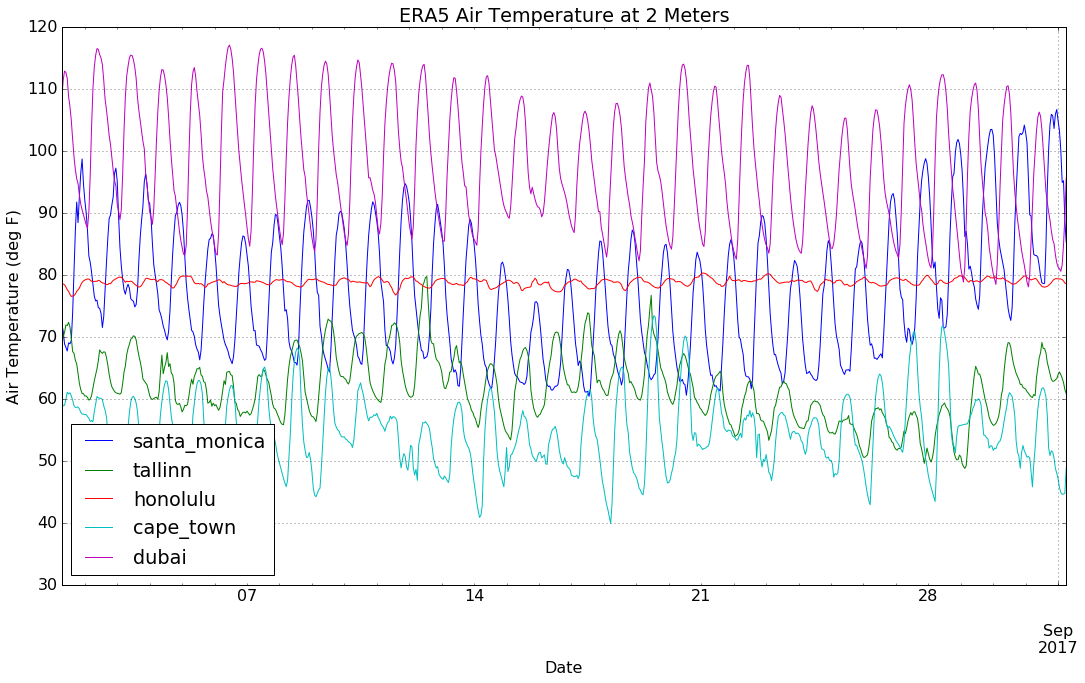

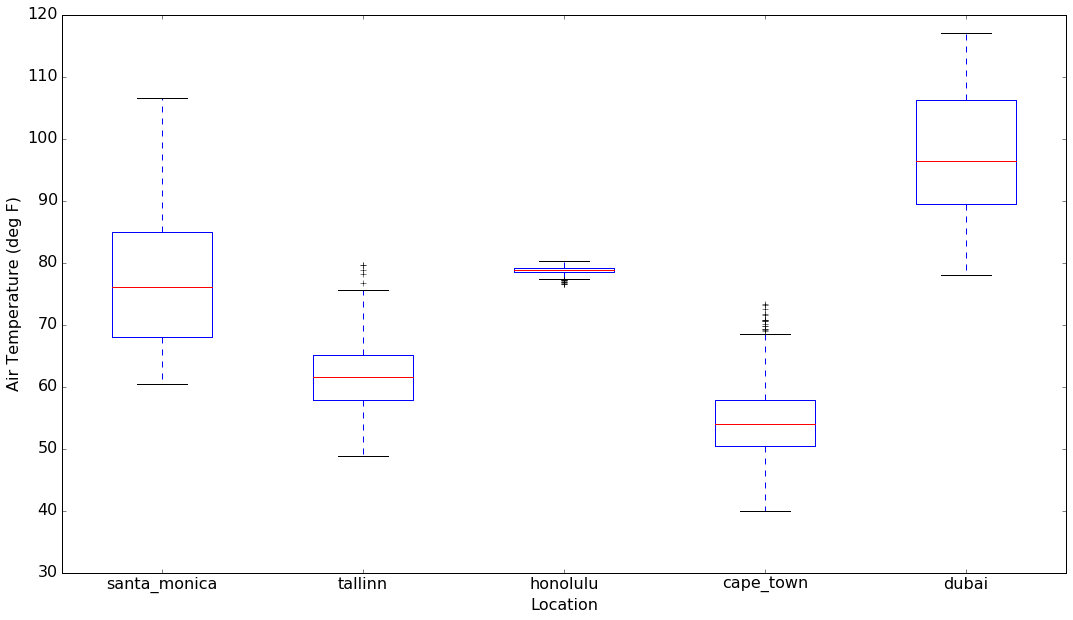

In [11]:
# readability please
plt.rcParams.update({'font.size': 16})

ax = df_f.plot(figsize=(18, 10), title="ERA5 Air Temperature at 2 Meters", grid=1)
ax.set(xlabel='Date', ylabel='Air Temperature (deg F)')
plt.show()

ax = df_f.plot.box(figsize=(18, 10))
ax.set(xlabel='Location', ylabel='Air Temperature (deg F)')
plt.show()

Conclusions? Dubai was absolutely cooking in August, with a mean temperature of ~98° and a high of 117°! While Honolulu was a consistent 78° with a standard deviation of less than 1°!

Questions? Feedback? Email us at [datahub@intertrust.com](mailto:datahub@intertrust.com). We also provide an API for accessing ERA5 data, for more details vis the [Planet OS Datahub](https://data.planetos.com/datasets/ecmwf_era5) or check out [another notebook example using ERA5 data.](https://github.com/planet-os/notebooks/blob/master/api-examples/ERA5_tutorial.ipynb)